# EGM722 Assignment- Interactive NBA map

## By Ronan McKenna


The aim of this notebook is to populate and display an interactive map that will show NBA team locations and information. Information included will be team records for the basic counting stats, Conference, Division, and accolades (NBA, Conference and Division titles)


To start, import what we need to run this.

In [ ]:
%matplotlib notebook

#import the necessary packages
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from shapely.ops import nearest_points
from shapely.geometry import Point


Then, we're going to load the data, for now, just the team locations points.

In [ ]:
Arenas = gpd.read_file('data-files/NBA_Arenas.shp') # load the shapefile
Arenas.head() # display the data


Now we'll visualise the map to get an idea of what the data looks like.

In [ ]:
m = Arenas.explore()
m # visualise the map

As we can see, it's pretty basic to look at at the moment. We also encounter a small issue with the LA Clippers not being displayed. They share their arena (for now) with the Lakers.

Now we're going to load the retired jersey list. The number 6 is retired league-wide for Bill Russell, hence every team has number 6 listed.

In [ ]:
jerseys = gpd.read_file('data-files/retired_jerseys.csv') # load the retired jersey data
jerseys.head() # display the table


This next section of code creates a dict() item and populates that dict with the teams and the numbers retired by each of those teams.

In [ ]:
retired_jerseys_list = dict() #creates the dict which the for loop will populate

for team in jerseys['team'].unique():         #this for loop cycles through each unique team in the jerseys list
      jersey_Numbers = jerseys.loc[jerseys['team'] == team, ('number')] 
      retired_jerseys_list.update({team: [jersey_Numbers.unique()] }) #this line updates the dict with each team
    
retired_jerseys_list   #display the output of the for loop

This next section of code creates a new data frame from the retired jerseys list and displays it so we can see how the data is arranged.

In [ ]:
jerseys_frame = pd.DataFrame(retired_jerseys_list)
jerseys_frame.head()

This data will need to be transposed before it can be Joined to the Arenas data frame.

In [ ]:
jerseys_frame = jerseys_frame.transpose() #transpose the dataframe
jerseys_frame.head() #display the dataframe, just to make sure it worked

Now this data frame is in a suitable arrangement to be joined.

i'm going to need to take this dataframe now, and apply column headers to enable a join to the Arena dataframe


In [ ]:
jerseys_frame['index1'] = jerseys_frame.index   #this adds an index column to the data frame to allow for joins
jerseys_frame.columns = ['retired numbers', 'team']   #adds names to the column headers
jerseys_frame[['team', 'retired numbers']]           
jerseys_frame.head() #display the dataframe, just to make sure it worked

Now to join the retired numbers to the Arenas dataframe

In [ ]:
Arenas = Arenas.join(jerseys_frame, on='team', how='left', lsuffix='', rsuffix=' ')
Arenas.head()

That last column 'team' is duplicate and unnecessary, so we'll drop it. We also nned to change the data type for the retired numbers column to display it properly on an interactive map.

In [ ]:
Arenas = Arenas.drop(Arenas.columns[[11]], axis=1)   #drop the duplicate column
convert_dict = {'retired numbers': str      #convert retired numbers column from a dict to a string
                }
 
Arenas = Arenas.astype(convert_dict)

One more thing to do is to adjust some of the data present. According to the L.A. Times (https://www.latimes.com/sports/clippers/story/2022-11-15/inside-steve-ballmer-perfect-nba-arena) the Clippers new arena will be located at the corner of Prairie and Century, just south west of SoFi Stadium. So we'll alter the geometry of the Clippers arena to allow them to be displayed on the map. Checking out the location on Google Earth shows that the area is under heavy construction. So we'll update the geometry to a point in this area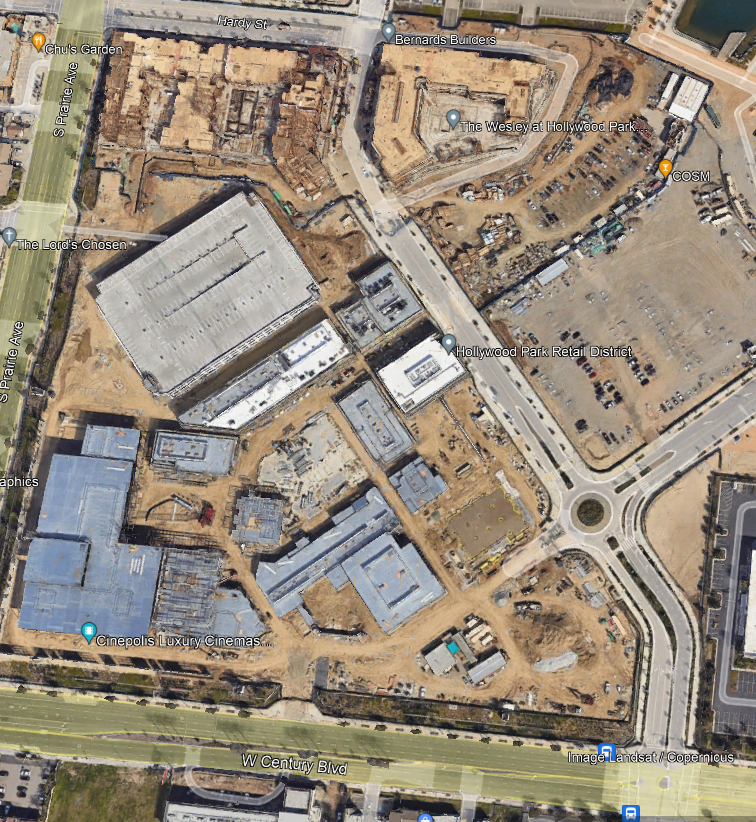

We'll also need to change the name of the Arena to the Intuit Dome. For the purpose of this exercise we'll use these coordinates: (-118.342258 33.94810 0.00000)

In [ ]:
print(Arenas)  #print the Arenas dataframe so we can see which index we need to use to alter entries

In [ ]:
Arenas.at[15, 'team']   #display the team first

Correct index, now to change the name in the arena column

In [ ]:
Arenas.at[15, 'arena']='Intuit Dome' #change the arena name
Arenas.at[15, 'arena']               #check it worked

The next step is to change the geometry to reflect the location of the new arena

In [ ]:
print(Arenas.at[15,'geometry']) #check the current coordinates of the arena

In [ ]:
Arenas.at[15, 'geometry'] =Point(-118.342258, 33.94810, 0.00000) # change the geometry entry to the new coordinates
print(Arenas.at[15,'geometry']) #print the geometry to check that it worked

In [ ]:
print(Arenas)

In [ ]:
Counties = gpd.read_file('data-files/cb_2018_us_county_500k.shp')
Counties.explore('NAME', 
                 m=m, # add the markers to the same map we just created
                 popup=False, # don't show the information as a popup when we click on the marker
                 legend=False, # don't show a separate legend for the point layer
                )

Arenas.explore('arena', 
                 m=m, # add the markers to the same map we just created
                 marker_type='marker', # use a marker for the points, instead of a circle 
                 popup=True, # show the information as a popup when we click on the marker
                 legend=False, # don't show a separate legend for the point layer
                )

Now, inspired by the maps that get produced during March Madness each year, I want to try to recreate it with the NBA. So we're going to try and colour coordinate the counties according to the closest NBA team. Then maybe try to create a function that will allow us to update the map as and when teams are eliminated to reflect the landscape of the remaining contenders.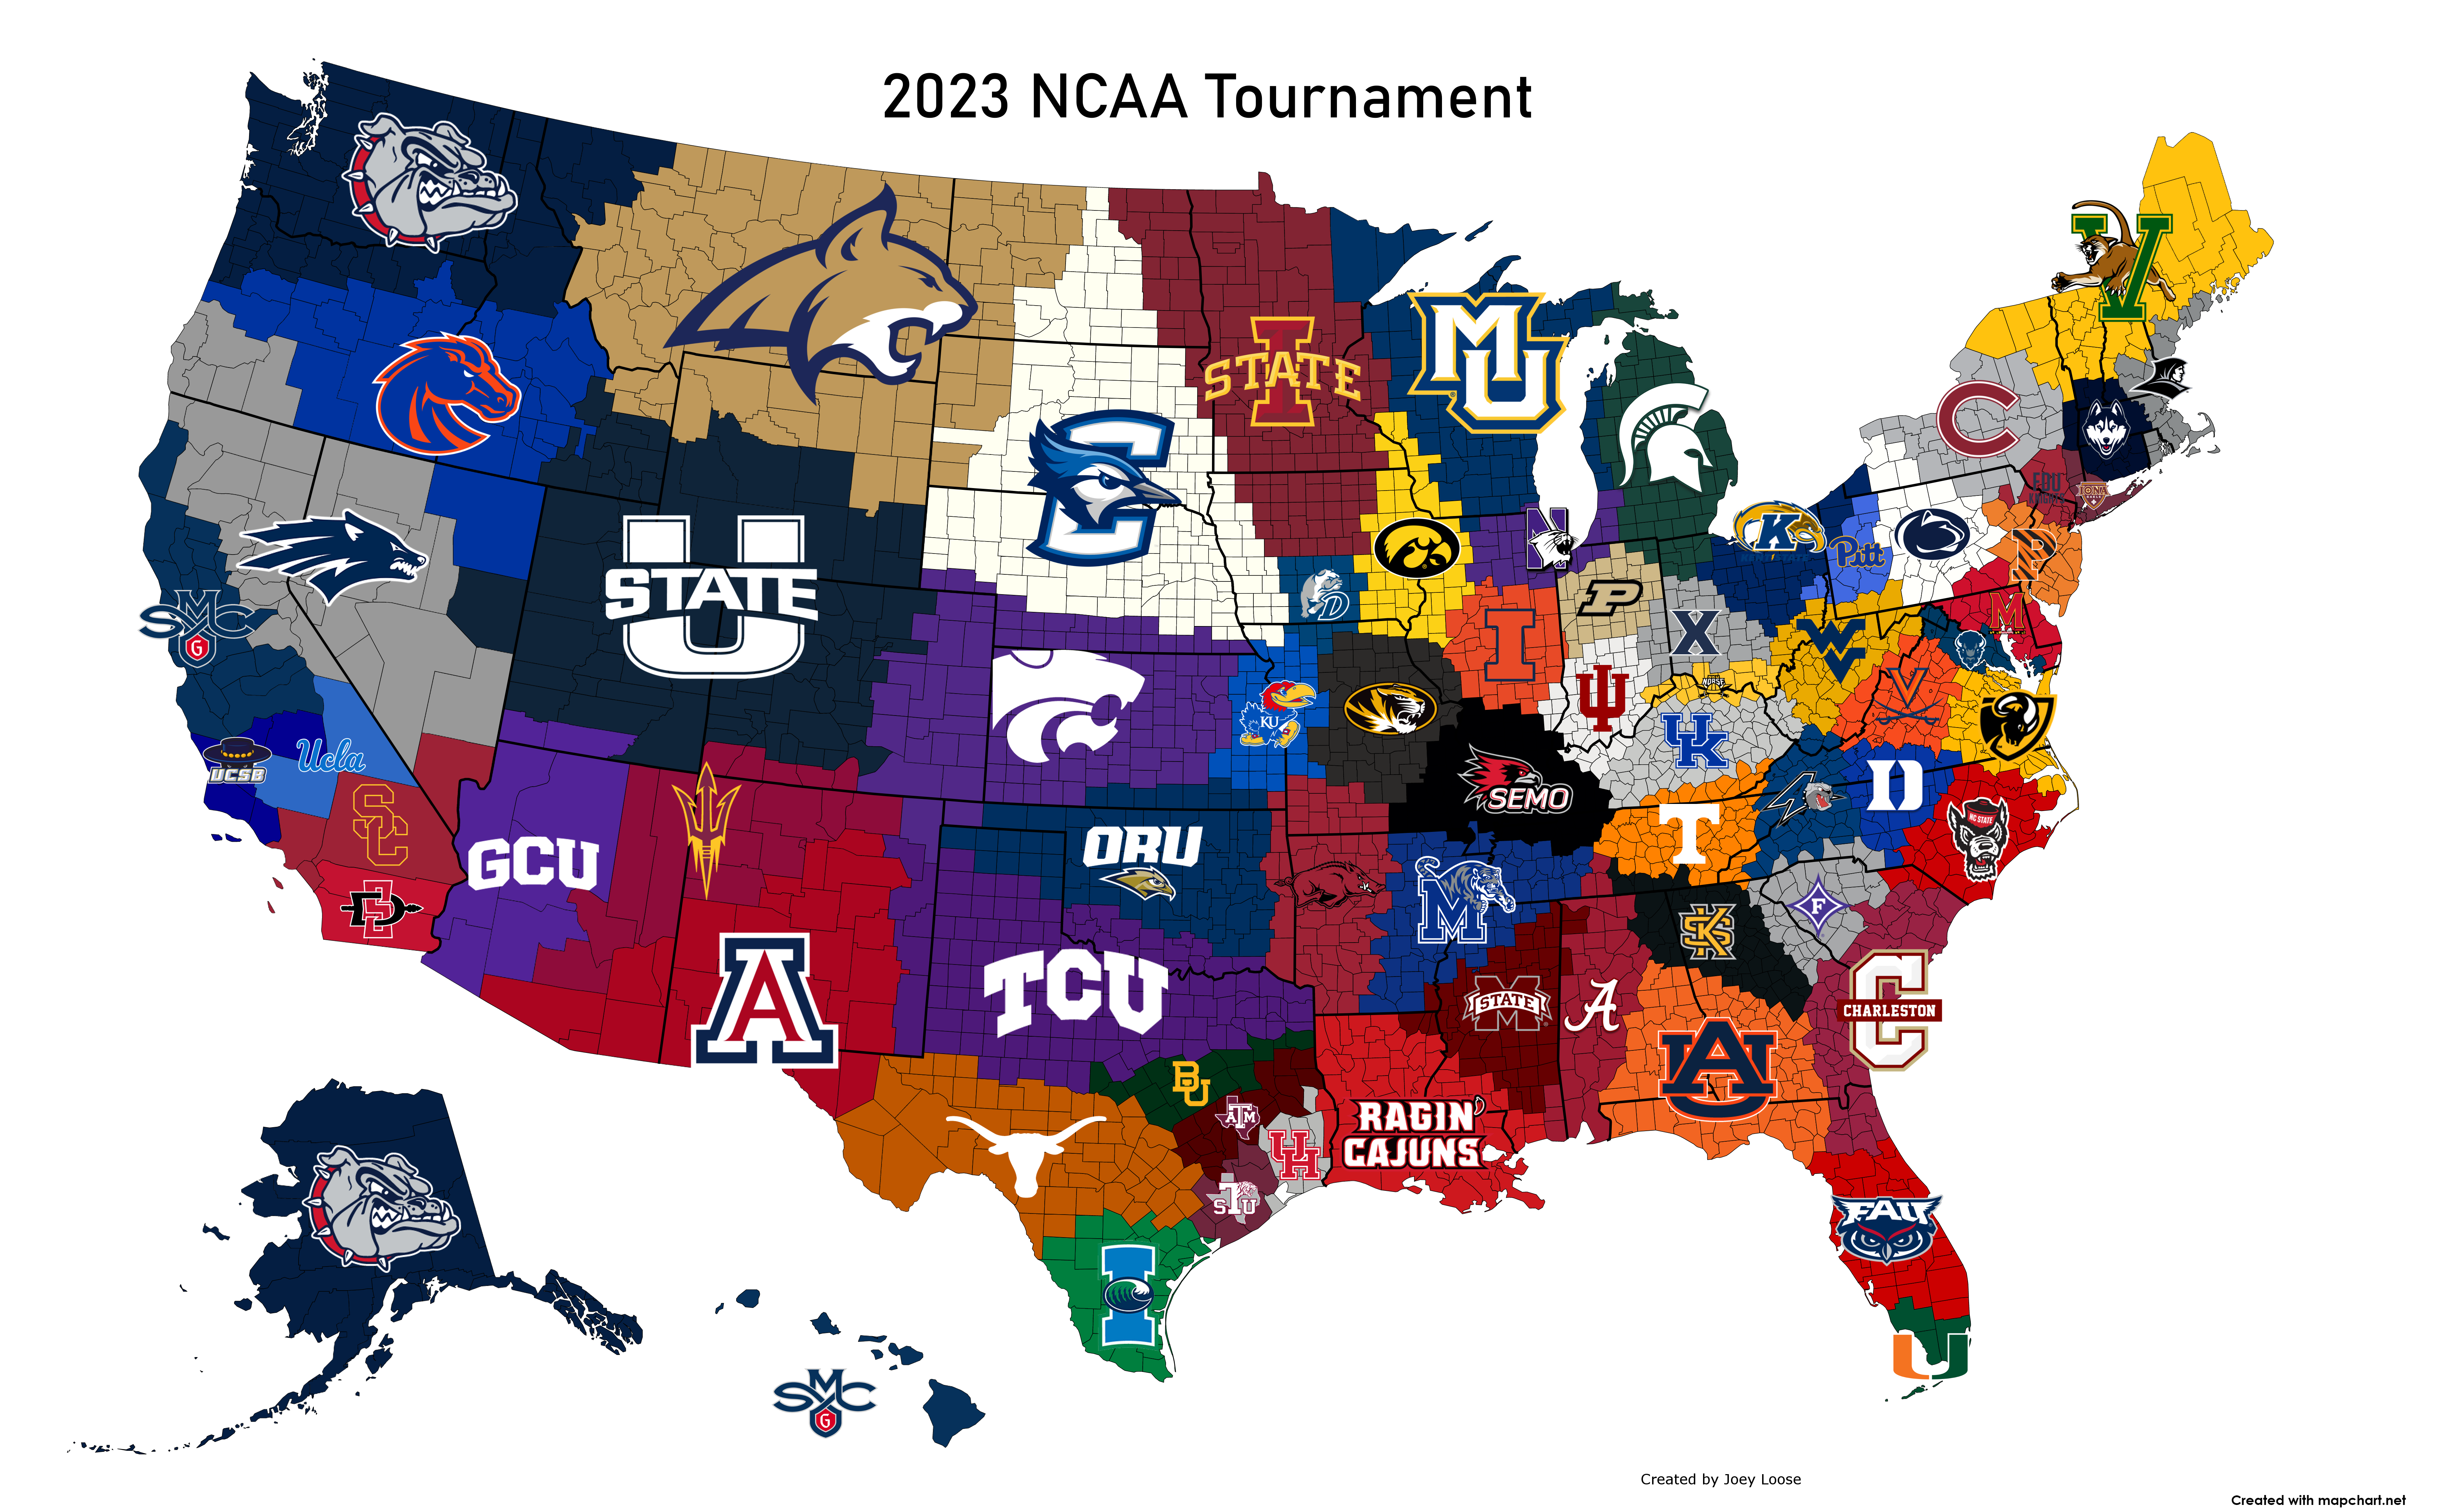 To do this, we will update the Arenas shapefile with another column called "In Contention" and assign a true/false value to it. Then maybe using that value as a decision on whether or not to display it on the map. We'll need to join the Arenas and Counties shapefiles together in order to develop the map.

So to start, let's take a look at what data is in the counties shapefile.

We need to change the CRS of both layers in order to perform geographic operations on them.

In [ ]:
Arenas=Arenas.to_crs(32610)
Counties=Counties.to_crs(32610)

In [ ]:
Arenas.insert(loc=11, column='In Contention', value=True)
Arenas.head()

This line adds a column to the Counties GeoDataFrame for the centroid of each County.

In [ ]:
Counties.insert(loc=10, column='Centroid', value=Counties['geometry'].centroid)
Counties.head()


In [ ]:
print(Counties)
States = gpd.read_file('data-files/cb_2018_us_state_500k.shp')
States = States.to_crs(32610)

This next line performs a spatial join between the arenas GeoDataFrame and the Counties GeoDataFrame based on the nearest Arena to each County centroid

In [ ]:
Counties = Counties.sjoin_nearest(Arenas, how='left', max_distance=None, lsuffix='Centroid', rsuffix='geometry', distance_col='distance')

The next code block change the column 'STATEFP' to type int allowing us to merge the two frame based on this attribute.

In [ ]:
States=States.loc[:,['STATEFP', 'NAME']]
States['STATEFP']=States['STATEFP'].astype(int)
Counties['STATEFP']=Counties['STATEFP'].astype(int)


Now we can merge the two dataframes and print the result

In [ ]:
Counties = Counties.merge(States, on='STATEFP')
print(Counties)

For display purposes, there is data we don't need so we need to drop some columns, running the next block allows us to see all data without abbreviation so we can determine which columns to keep.

In [ ]:
pd.set_option('display.max_columns',None)# this will allow us to see all columns with abbreviation
Counties.head()                            #allowing us to easily chop out the data we don't need

This next line will keep all columns with these headers.

In [ ]:
Counties = Counties.loc[:,[ 'NAME_x','geometry',  'team', 'In Contention', 'distance', 'NAME_y' ]]
Counties.head()

Now we rename the columns to be more readable.

In [ ]:
Counties.columns = ['County', 'geometry', 'Closest Team', 'In Contention', 'Distance from Arena', 'State']
Counties.head()

Now, we're going to create a new map and populate it. Adjusting symbology and colour displays to clearly display the information.

In [ ]:
State_lines = gpd.read_file('data-files/cb_2018_us_state_500k.shp') #we'll create a fresh instance of the tates shapefile again
State_lines = State_lines.to_crs(32610)

State_lines_args = {
    'm': m, # add the markers to the same map we just created
    'color': 'black',
    'legend': False,
    'highlight':False, 
    'popup': False,
    'tooltip': False,
    'style_kwds': {"fill":False, 'fillOpacity':0, 'weight':1.25}
}


Counties_args = {'m': m, 
                 'cmap':'turbo', # add the markers to the same map we just created
                 'popup':True, # show the information as a popup when we click on the marker
                 'legend':False, # don't show a separate legend for the point layer
                 'style_kwds': {"fillOpacity":1, 'color':'black','weight': 0.25}
                }


Arenas_args = {
    'm': m, # add the markers to the same map we just created
    'marker_type': 'marker', # use a marker for the points, instead of a circle
    'popup': True, # show the information as a popup when we click on the marker
    'legend': False, # don't show a separate legend for the point layer
    'marker_kwds': {'icon': folium.Icon(color='red', icon='basketball', prefix='fa')} # make the markers red with a plane icon from FA
}

m=Counties.explore('Closest Team', **Counties_args)
Arenas.explore('team', **Arenas_args)
State_lines.explore(**State_lines_args)

m


Now we add a line of code to save the map to an HTML file

In [ ]:
m.save('NBA_Map.html')

## Changing the map using functions

The next stage of this project will be to create a function that will alter the In Contention status to false to show that a team has been eliminated from championship contention, it will then recalculate the map to display what is the closest team remaining after that point. 

In [ ]:
def cancun(team):                  #this function will take the argument of a team name and change its contender status to false
    '''
    eliminate a team from contention and recalculate the map
    
    team: the team that is to be eliminated from contention
    '''
    GoneFishin = Arenas.update(Arenas['In Contention'].loc[Arenas['team'] == team].replace(True, False)) #select the team based on the function argument


This first block will update the teams that did not make the playoffs in any fashion

In [ ]:
cancun('Orlando Magic')
cancun('Charlotte Hornets')
cancun('Detroit Pistons')
cancun('Washington Wizards')
cancun('Indiana Pacers')
cancun('San Antonio Spurs')
cancun('Houston Rockets')
cancun('Portland Trailblazers')
cancun('Dallas Mavericks')
cancun('Utah Jazz')

This block updates the teams that were eliminated after the first play-in game

In [ ]:
cancun('Toronto Raptors')
cancun('New Orleans Pelicans')

This block updates the teams that were eliminated after the second play-in game

In [ ]:
cancun('Chicago Bulls')
cancun('Oklahoma City Thunder')

This updates the teams that were eliminated as of 26/04/2023

In [ ]:
cancun('Brooklyn Nets')
cancun('Minnesota Timberwolves')
cancun('Los Angeles Clippers')



print(Arenas)


In [ ]:
State_lines = gpd.read_file('data-files/cb_2018_us_state_500k.shp') #we'll create a fresh instance of the tates shapefile again
State_lines = State_lines.to_crs(32610)

State_lines_args = {
    'm': m, # add the markers to the same map we just created
    'color': 'black',
    'legend': False,
    'highlight':False, 
    'popup': False,
    'tooltip': False,
    'style_kwds': {"fill":False, 'fillOpacity':0, 'weight':1.25}
}


Counties_args = {'m': m, 
                 'cmap':'turbo', # add the markers to the same map we just created
                 'popup':True, # show the information as a popup when we click on the marker
                 'legend':False, # don't show a separate legend for the point layer
                 'style_kwds': {"fillOpacity":1, 'color':'black','weight': 0.25}
                }


Arenas_args = {
    'm': m, # add the markers to the same map we just created
    'marker_type': 'marker', # use a marker for the points, instead of a circle
    'popup': True, # show the information as a popup when we click on the marker
    'legend': False, # don't show a separate legend for the point layer
    'marker_kwds': {'icon': folium.Icon(color='red', icon='basketball', prefix='fa')} # make the markers red with a plane icon from FA
}

m=Counties.explore('Closest Team', **Counties_args)
Arenas.explore('team', **Arenas_args)
State_lines.explore(**State_lines_args)

m

Ok, so, hit a snag on 26/04/2023, by writing the code in one location, copy-pasting the file to another I have accidentally been overwriting all of the commit history for this piece of work (I've been basically operating things in a strange fashion all year in order to try and overcome the lack of storage space on this computer). So to get around this I have got a free  trial of pycharm pro to get me over the finish line of this assignment. Hopefully this commit now won't wipe out the previous ones.